In [ ]:
# we are going to load a dataset from scratch, implementing it as an 'InMemoryDataset'

# Load a new dataset

In [33]:
import torch
import os
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data, download_url, extract_zip
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob

In [36]:
raw_dir = 'dataset/'

In [45]:
datalist = glob.glob(raw_dir + 'FRANK*')

In [46]:
datalist

['dataset/FRANKENSTEIN.zip',
 'dataset/FRANKENSTEIN.edges',
 'dataset/FRANKENSTEIN.graph_idx',
 'dataset/FRANKENSTEIN.graph_labels',
 'dataset/FRANKENSTEIN.node_attrs',
 'dataset/FRANKENSTEIN.readme']

In [59]:
for i,data in enumerate(datalist):
    if data.endswith('attrs'):
        node_attrs = pd.read_csv(datalist[i])
        node_attrs.index += 1
        
    elif data.endswith('edges'):
        edge_index = pd.read_csv(datalist[i], sep=',', names=['source', 'target'])
        edge_index.index += 1
        
    elif data.endswith('idx'):
        graph_idx = pd.read_csv(datalist[i], sep=',', names=['idx'])
        graph_idx.index += 1
        
    elif data.endswith('labels'):
        graph_labels = pd.read_csv(datalist[i], sep=',', names=['label'])
        graph_labels.index += 1
        
    else:
        pass

In [63]:
g_idx = 2345

node_ids = graph_idx.loc[graph_idx['idx']==g_idx].index

# node features
attributes = node_attrs.loc[node_ids, :]

# edges info
edges = edge_index.loc[edge_index['source'].isin(node_ids)]
edges_ids = edges.index

# graph label
label = graph_labels.loc[g_idx]

In [69]:
print(f'Nodes: {node_ids.shape}')
print(f'Attributes: {attributes.shape}')
print(f'Edges: {edges.shape}')
print(f'Label: {label.shape}')

Nodes: (18,)
Attributes: (18, 780)
Edges: (38, 2)
Label: (1,)


At this stage the indices in the 'edges' variable are not normalized for the single graph, e.g. they do not start from 0

In [70]:
edge_idx = torch.tensor(edges.to_numpy().transpose(), dtype=torch.long)
map_dict = {v.item():i for i,v in enumerate(torch.unique(edge_idx))}
map_edge = torch.zeros_like(edge_idx)
for k,v in map_dict.items():
    map_edge[edge_idx==k] = v

In [77]:
map_dict, map_edge, map_edge.shape

({38571: 0,
  38572: 1,
  38573: 2,
  38574: 3,
  38575: 4,
  38576: 5,
  38577: 6,
  38578: 7,
  38579: 8,
  38580: 9,
  38581: 10,
  38582: 11,
  38583: 12,
  38584: 13,
  38585: 14,
  38586: 15,
  38587: 16,
  38588: 17},
 tensor([[ 0,  1,  0,  2,  0,  3,  1,  4,  1,  5,  2,  6,  3,  7,  4,  8,  4,  9,
           6, 10,  7, 10, 10, 11, 11, 12, 12, 13, 12, 14, 13, 15, 14, 16, 15, 17,
          16, 17],
         [ 1,  0,  2,  0,  3,  0,  4,  1,  5,  1,  6,  2,  7,  3,  8,  4,  9,  4,
          10,  6, 10,  7, 11, 10, 12, 11, 13, 12, 14, 12, 15, 13, 16, 14, 17, 15,
          17, 16]]),
 torch.Size([2, 38]))

As final step we convert the 'DataFrames' to torch tensors. The node features are bascially MNIST images, therefore their size should be 784(28x28), but for some reason the files provide vectors of length 780. to adjust this,we simply add a padding of 4 zeros at the end of the vector 

In [79]:
attrs = torch.tensor(attributes.to_numpy(), dtype=torch.long)
pad = torch.zeros((attrs.shape[0], 4), dtype=torch.float)
x = torch.cat((attrs, pad), dim=-1)

edge_idx = map_edge.long()
np_lab = label.to_numpy()
y = torch.tensor(np_lab if np_lab[0] == 1 else [0], dtype=torch.long)

In [84]:
graph = Data(x=x, edge_index=edge_idx, y=y)

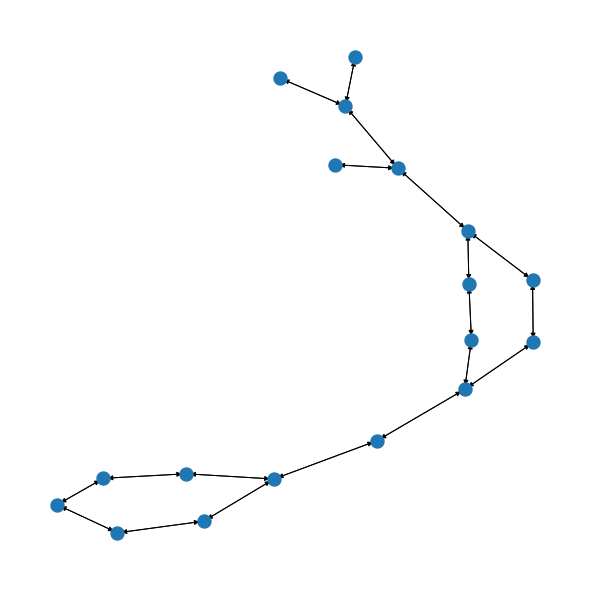

In [87]:
vis = to_networkx(graph)
plt.figure(1, figsize=(8,8))
nx.draw(vis,
       cmap=plt.get_cmap('Set3'),
       node_size=70,
       linewidths=6)
plt.show()

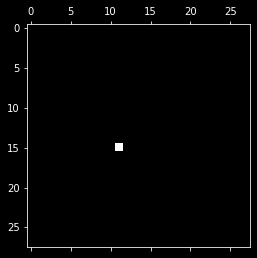

In [97]:
digit = x[10].reshape(28,28)
plt.style.use(['dark_background'])
plt.matshow(digit, cmap='gray')

Let's now put the process above into the 'Dataset' class of PyG. Specifically, we are going to create an 'InMemoryDataset'. From the official PyG documentation we see that some methods need to be override.

In [ ]:
'''
dataset class rewriting here 'homework'
'''

# Open Graph Benchmark dataset

In [99]:
from ogb.nodeproppred import PygNodePropPredDataset

Using backend: pytorch


In [101]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name = dataset_name, root='./dataset/')

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx['train'], split_idx['valid'], split_idx['test']
graph = dataset[0]

Downloaded 0.08 GB: 100%|███████████████████████████████████████████████████████████████████████████| 81/81 [03:50<00:00,  2.84s/it]


Extracting ./dataset/arxiv.zip
Processing...
Loading necessary files...
This might take a while.
Processing graphs...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5607.36it/s]


Converting graphs into PyG objects...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3869.28it/s]

Saving...


Done!


In [102]:
graph

Data(edge_index=[2, 1166243], node_year=[169343, 1], x=[169343, 128], y=[169343, 1])

# Benchmarking Graph Neural Networks Datasets

In [105]:
import torch_geometric.datasets as datasets

datasets.__all__

['KarateClub',
 'TUDataset',
 'GNNBenchmarkDataset',
 'Planetoid',
 'NELL',
 'CitationFull',
 'CoraFull',
 'Coauthor',
 'Amazon',
 'PPI',
 'Reddit',
 'Reddit2',
 'Flickr',
 'Yelp',
 'AmazonProducts',
 'QM7b',
 'QM9',
 'ZINC',
 'MoleculeNet',
 'Entities',
 'GEDDataset',
 'MNISTSuperpixels',
 'FAUST',
 'DynamicFAUST',
 'ShapeNet',
 'ModelNet',
 'CoMA',
 'SHREC2016',
 'TOSCA',
 'PCPNetDataset',
 'S3DIS',
 'GeometricShapes',
 'BitcoinOTC',
 'ICEWS18',
 'GDELT',
 'DBP15K',
 'WILLOWObjectClass',
 'PascalVOCKeypoints',
 'PascalPF',
 'SNAPDataset',
 'SuiteSparseMatrixCollection',
 'TrackMLParticleTrackingDataset',
 'AMiner',
 'WordNet18',
 'WordNet18RR',
 'WikiCS',
 'WebKB',
 'WikipediaNetwork',
 'Actor',
 'JODIEDataset',
 'MixHopSyntheticDataset',
 'UPFD',
 'GitHub',
 'FacebookPagePage',
 'LastFMAsia',
 'DeezerEurope',
 'GemsecDeezer',
 'Twitch']

In [108]:
datasets.GNNBenchmarkDataset.names

['PATTERN', 'CLUSTER', 'MNIST', 'CIFAR10', 'TSP', 'CSL']

In [ ]:
dataset = datasets.GNNBenchmarkDataset(name='MNIST', root='./dataset')

In [ ]:
dataset